# Build RNN Regression Model

**Using the airline passengers dataset, build a Recurrent Neural Network using LSTM or GRU units.**

**You need to build the regression 'supervised' dataset to train the model, and predict using one-step, incremental multi-step and multi-output multi-step forecasting methods.**

**There are three main ways to build the RNN model for a time series:**

* **Keep the final hidden state vector only from RNN then pass through final Dense layer, i.e. basic RNN.**
* **Keep all hidden states then perform Global Max Pooling to get a single hidden vector.**
* **Stack multiple RNN layers where all hidden states are returned except for the final RNN layer, before passing through the final Dense layer.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

%matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

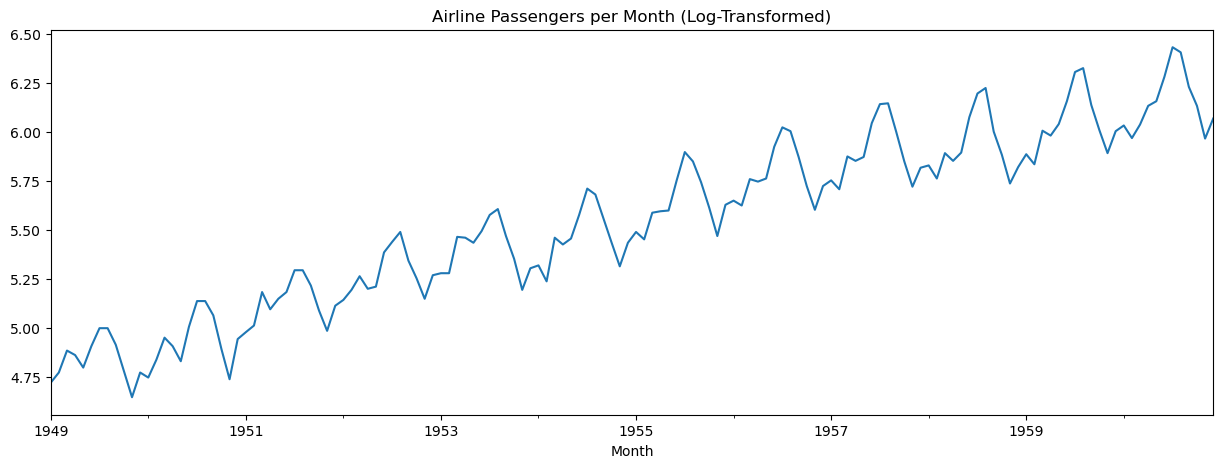

In [6]:
df['LogPassengers'].plot(figsize=(15, 5))
plt.title("Airline Passengers per Month (Log-Transformed)");

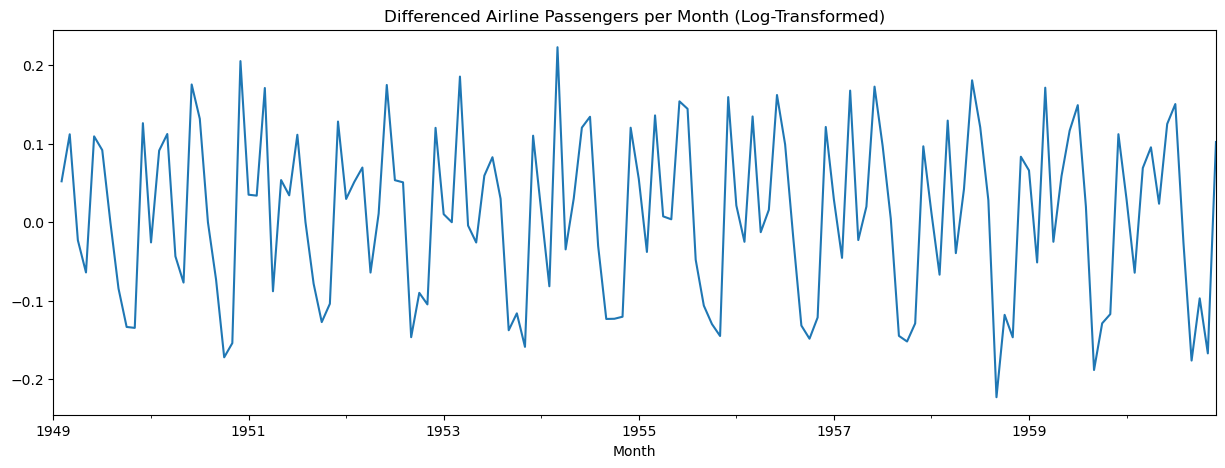

In [7]:
df['DiffLogPassengers'].plot(figsize=(15, 5))
plt.title("Differenced Airline Passengers per Month (Log-Transformed)");

In [8]:
# Last 12 timesteps/values used in test set

Ntest = 12

train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
# Boolean series to index df rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [10]:
# Make supervised dataset for one-step and multi-step forecasts

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

# Convert to NumPy array - input is N x T x D
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [11]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-Ntest], Y[:-Ntest]

X_test, y_test = X[-Ntest:], Y[-Ntest:]

In [12]:
# Basic RNN (keep final hidden state only)

i = Input(shape=(T, 1))

x = LSTM(24)(i)

x = Dense(1)(x)

model = Model(i, x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer='adam')

In [15]:
r = model.fit(X_train, 
              y_train, 
              epochs=100, 
              validation_data=(X_test, y_test))

Epoch 1/100
4/4 [==============================] - 2s 139ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 11/100
4/4 [

Epoch 84/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 85/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 86/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 87/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 88/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 89/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 90/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 91/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 92/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 93/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 94/1

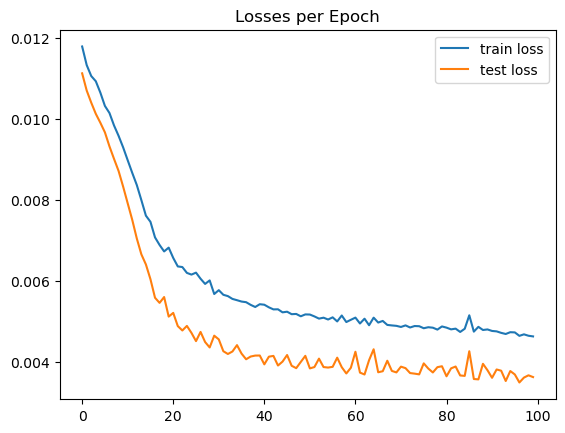

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

**Interestingly, the test losses are below the train losses, but both have converged, with some stochastic behaviour.**

## One-Step Forecast

In [17]:
# Remember that first T + 1 values are not predictable

train_idx[:T+1] = False 

In [18]:
P_train = model.predict(X_train).flatten()

P_test = model.predict(X_test).flatten()

1/1 [==============================] - 0s 17ms/step


In [19]:
# Compute un-differenced predictions

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)

prev = df['ShiftLogPassengers']

In [20]:
# Obtain last-known training value for multi-step forecast

last_train = train.iloc[-1]['LogPassengers']

In [21]:
# Store one-step forecast to df

df.loc[train_idx, 'onestep_train'] = prev[train_idx] + P_train

df.loc[test_idx, 'onestep_test'] = prev[test_idx] + P_test

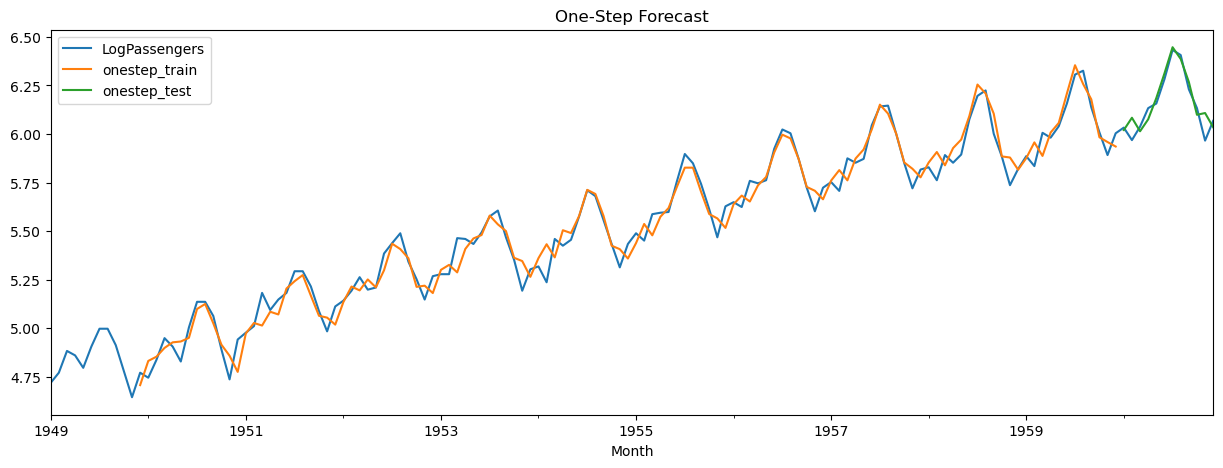

In [22]:
df[['LogPassengers', 'onestep_train', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-Step Forecast");

**One-step forecasts look pretty good, but remember that this is just predicting the next value.**

## Multi-Step Forecast

In [25]:
multistep_predictions = []

# First test input
last_x = X_test[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 24ms/step


In [26]:
# Save multi-step forecast to df

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

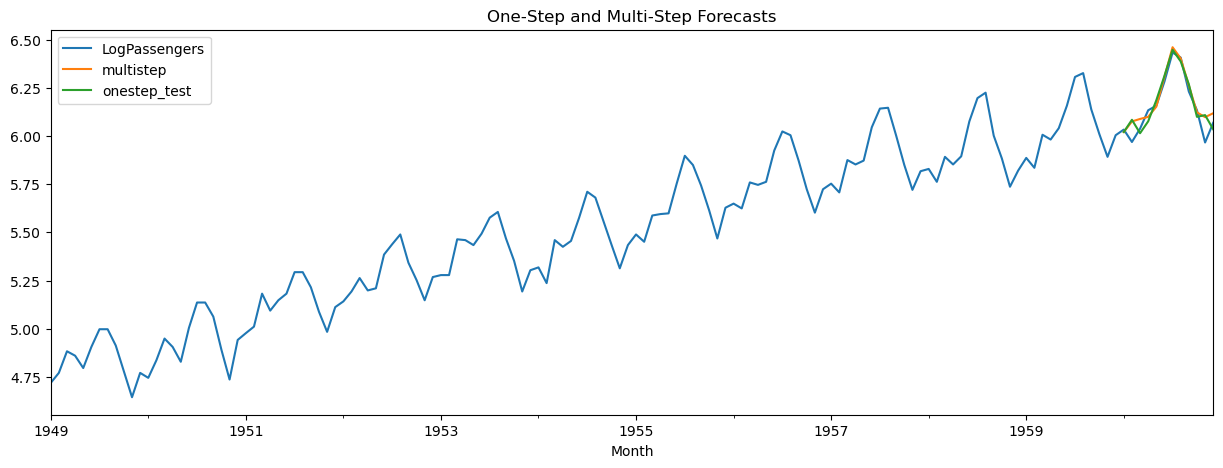

In [27]:
df[['LogPassengers', 'multistep', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-Step and Multi-Step Forecasts");

**Difficult to tell which outperforms as they are both pretty close, but it looks like the one-step is slightly better because it is using actual true past data.**

## Multi-Output Forecast

In [28]:
# Make multi-output supervised dataset

Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
# Convert to NumPy arrays - input is N x T x D
X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [29]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

In [30]:
# Build RNN - keep all hidden states and add Global Max Pooling layer to choose best values

i = Input(shape=(Tx, 1))

x = LSTM(24, return_sequences=True)(i)

x = GlobalMaxPooling1D()(x)

x = Dense(Ty)(x)

model = Model(i, x)

In [31]:
# Create checkpoint - see in data folder

check_point = ModelCheckpoint('data/best_model.h5', monitor='val_loss', save_best_only=True)

In [32]:
model.compile(loss='mse', optimizer='adam')

In [33]:
r = model.fit(Xtrain, 
              Ytrain, 
              epochs=300, 
              validation_data=(Xtest, Ytest), 
              callbacks=[check_point])

Epoch 1/300
4/4 [==============================] - 2s 175ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 2/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 3/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 4/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 6/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 7/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 8/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 9/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 10/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 11/300
4/4 [

Epoch 84/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 85/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 86/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 87/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 88/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 89/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 90/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 91/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 92/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 93/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 94/3

4/4 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 167/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 168/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 169/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 170/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 171/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 172/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 173/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 174/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 175/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 176/300


4/4 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 249/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 250/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 251/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 252/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 253/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 254/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 255/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 256/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 257/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 258/300


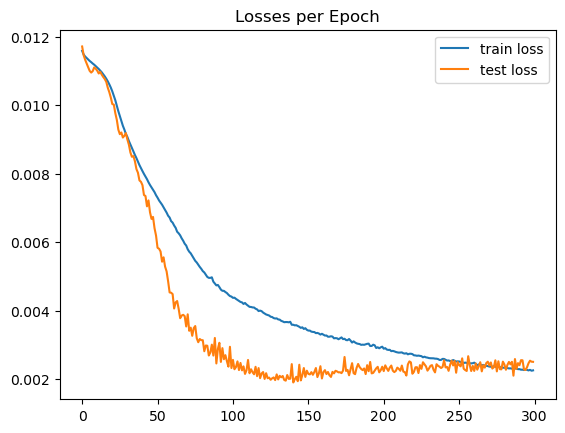

In [34]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

**Again the test losses are lower than the train losses, but both converge and the test loss looks to be creeping upwards so you do not need to add more epochs.**

In [35]:
# Load best model

best_model = tf.keras.models.load_model('data/best_model.h5')

In [36]:
# Predict with model

Ptrain = model.predict(Xtrain)

Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 18ms/step


In [37]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [38]:
# Grab closest value since most likely

Ptrain = Ptrain[:, 0]

Ptest = Ptest[0]

In [39]:
# Save multi-output forecast to df

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

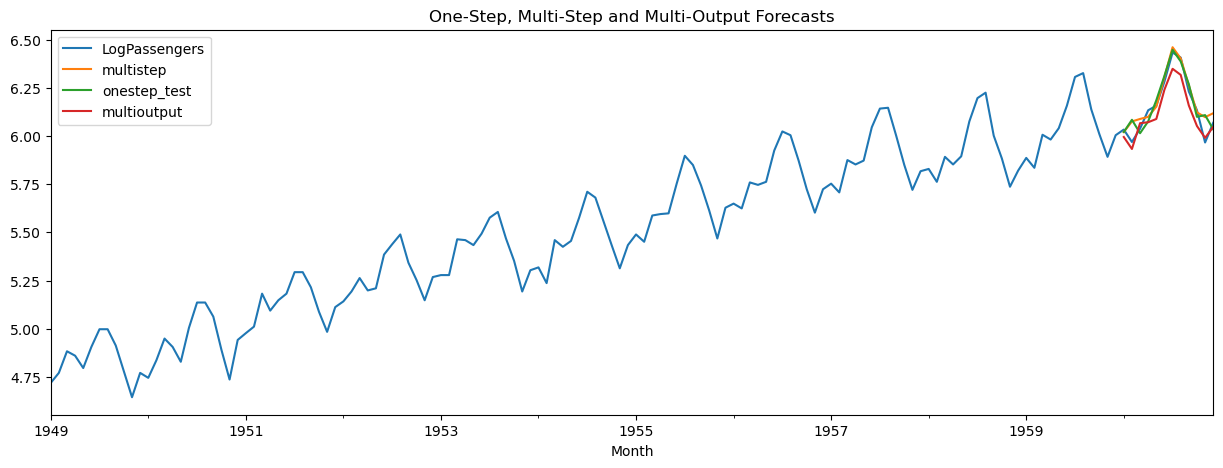

In [40]:
cols = ['LogPassengers', 'multistep', 'onestep_test', 'multioutput']

df[cols].plot(figsize=(15, 5))
plt.title("One-Step, Multi-Step and Multi-Output Forecasts");

**Multi-output forecast looks to be slightly better than the one-step but underestimates the peaks...only performance metrics can determine which is best.**

**You can try the multi-output dataset with differently-configured RNN to see if performance improves on current multi-output.**

## Add multiple LSTM layers to Multi-Output Model

**In this case, you can return all hidden states in every layer until the last layer, where you only keep the final hidden state, or you can return all hidden states and use Global Average or Global Max Pooling, where you take the average or highest value. In this case, it makes sense to take the highest value as that means the best hidden state value.**

In [41]:
i = Input(shape=(Tx, 1))

x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)

x = GlobalMaxPooling1D()(x)

x = Dense(Ty)(x)

model = Model(i, x)

In [42]:
# Create checkpoint - see in data folder (overwrite other best model)

check_point = ModelCheckpoint('data/best_model.h5', monitor='val_loss', save_best_only=True)

In [43]:
model.compile(loss='mse', optimizer='adam')

In [44]:
r = model.fit(Xtrain, 
              Ytrain, 
              epochs=300, 
              validation_data=(Xtest, Ytest), 
              callbacks=[check_point])

Epoch 1/300
4/4 [==============================] - 4s 201ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 2/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 3/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 5/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 8/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 9/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 10/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 11/300
4/4 [

Epoch 84/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 85/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 86/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 87/300
4/4 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 88/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 89/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 90/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 91/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 92/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 93/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 94/3

4/4 [==============================] - 0s 20ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 167/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 168/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 169/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 170/300
4/4 [==============================] - 0s 20ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 171/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 172/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 173/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 174/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 175/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 176/300


4/4 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 249/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 250/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 251/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 252/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 253/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 254/300
4/4 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 255/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 256/300
4/4 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 257/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 258/300


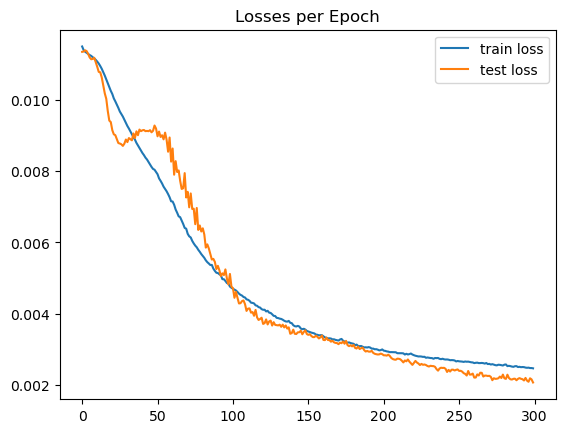

In [45]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

**Interesting behaviour but both training and test losses converge and seem to be still decreasing. More epochs might be more revealing.**

In [46]:
# Load best model

best_model = tf.keras.models.load_model('data/best_model.h5')

In [47]:
# Predict with model

Ptrain = model.predict(Xtrain)

Ptest = model.predict(Xtest)

# Grab closest value per timestep

Ptrain = Ptrain[:,0]

Ptest = Ptest[0]

1/1 [==============================] - 0s 19ms/step


In [48]:
# Save multi-output forecast to df

df.loc[test_idx, 'multioutput2'] = last_train + np.cumsum(Ptest)

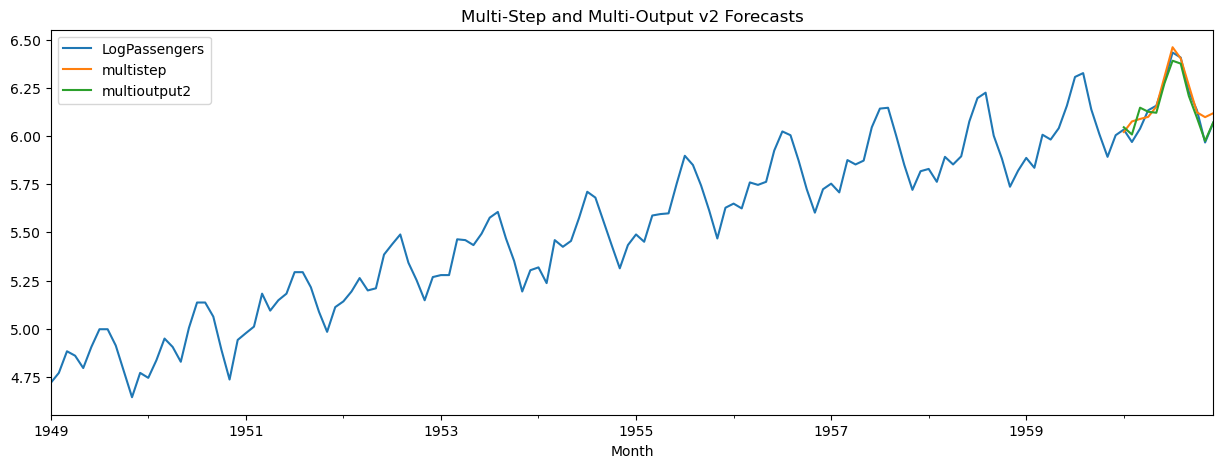

In [49]:
cols = ['LogPassengers', 'multistep', 'multioutput2']

df[cols].plot(figsize=(15, 5))
plt.title("Multi-Step and Multi-Output v2 Forecasts");

**Using multiple layers seems to have improved the multi-output forecast, making it much closer than the incremental multi-step forecast.**

In [50]:
# Compute MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

mape3 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.006710164861929331
multi-output MAPE: 0.00873045477429355
multi-output (2 LSTMs) MAPE: 0.004873594865210472


**Confirming that multi-output forecasts using multiple LSTM layers yields the best results, with the lowest MAPE score.**

**EXERCISE:**

* **Is the improvement due to global max pooling? Or due to multiple LSTMs layers? What about using GRU? Remember that the number of hidden neurons will affect behaviour.**
* **Do you think differencing is unnecessary? Try it!**
* **Do you think logging is unnecessary? Try it!**
* **Do you think including more past lags (*T*) would be useful?**
* **Have you considered walk-forward validation to optimize hyperparameters?**